In [49]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime
import pytz

data_dir = '../../data/'

In [50]:
data = pd.read_csv(data_dir + 'concat/MWRA_seagrant_concat_batch.csv'
                   , parse_dates=['PROF_DATE_TIME_LOCAL'])
# GET only the data from the 2019 season using datetime
data = data[data['PROF_DATE_TIME_LOCAL'] >= datetime(2018, 1, 1, tzinfo=pytz.UTC)]
data = data[data['PROF_DATE_TIME_LOCAL'] < datetime(2019, 1, 1, tzinfo=pytz.UTC)]
sal_and_ta = data[(data['SAL (PSU)'].notnull()) & (data['TA in (mmol/kgSW)'].notnull())]
sal = data[data['SAL (PSU)'].notnull()]

# Multifidelity modeling of Total Alkalinity

## Low Fidelity Data
Hunt 2021: Gulf of Maine Historical Relationship
TA(micro mol/kg) = SAL(g/kg) * 47.6 + 643

<img src="hunt2021.jpg" alt="drawing" width="300"/>

In [4]:
def lofi(sal):
    return 47.6 * sal + 643

In [51]:
predicted_ta = lofi(sal['SAL (PSU)'])
sal['TA in (mmol/kgSW)'] = predicted_ta
lofi_pos = sal[['LATITUDE', 'LONGITUDE']].values
lofi_ta = sal['TA in (mmol/kgSW)'].values

/var/folders/48/8wmkrk0n7zv6l_5n7nb7g9dr0000gn/T/ipykernel_27020/2960628026.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sal['TA in (mmol/kgSW)'] = predicted_ta


## High Fidelity Data
Shell day and MWRA data

In [52]:
hifi_pos = sal_and_ta[['LATITUDE', 'LONGITUDE']].values
hifi_ta = sal_and_ta['TA in (mmol/kgSW)'].values

### Correlation between low and high fidelity data

Text(0, 0.5, 'TA measured (mmol/kgSW)')

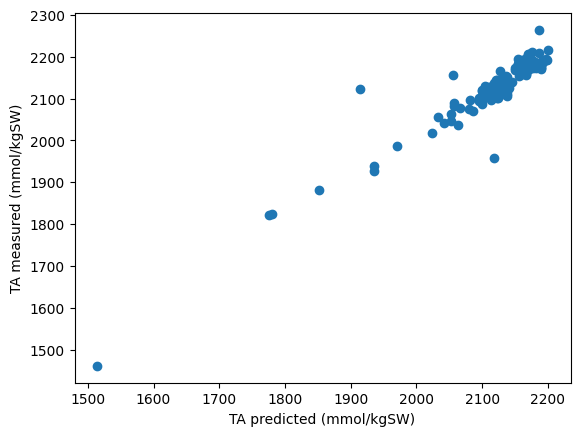

In [53]:
# use the lofi model to predict TA from salinity in a new column
predicted_ta = sal_and_ta['SAL (PSU)'].apply(lofi)

# Plot the lofi model against the hifi data
plt.scatter(predicted_ta, sal_and_ta['TA in (mmol/kgSW)'])
plt.xlabel('TA predicted (mmol/kgSW)')
plt.ylabel('TA measured (mmol/kgSW)')

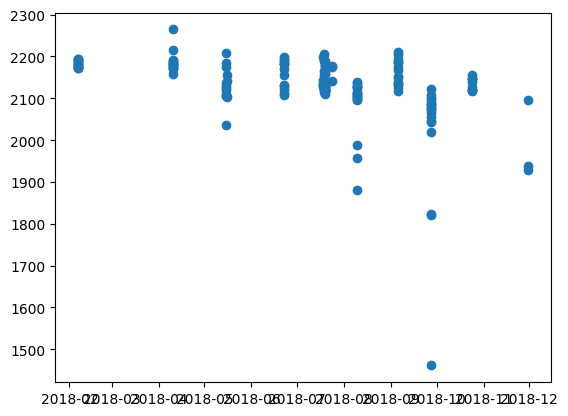

In [54]:
# Plot total alkalinity vs time
plt.scatter(sal_and_ta['PROF_DATE_TIME_LOCAL'], sal_and_ta['TA in (mmol/kgSW)'])

In [55]:
# Combine lofi_pos and hifi_pos into a single array
pos = np.concatenate((lofi_pos, hifi_pos))

# Combine lofi_ta and hifi_ta into a single array
ta = np.concatenate((lofi_ta, hifi_ta))

In [15]:
import math
import torch
import tqdm
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

from gpytorch.models import ExactGP
from gpytorch.kernels import GaussianSymmetrizedKLKernel, ScaleKernel
from gpytorch.means import ConstantMean

In [56]:
train_x = torch.from_numpy(pos).float()
train_y = torch.from_numpy(ta).float()

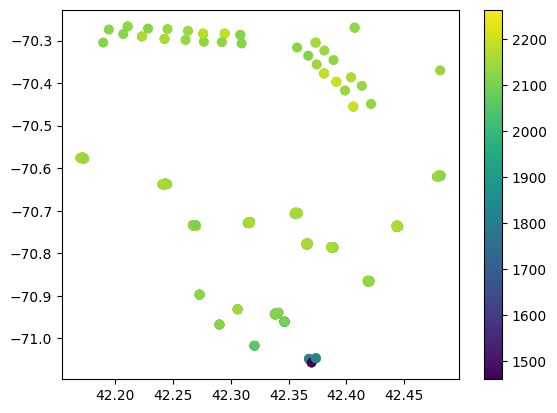

In [68]:
# Plot the 3d x values vs the 1d y values
plt.scatter(train_x[:, 0], train_x[:, 1], c=train_y)
plt.colorbar()

In [58]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [59]:
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [61]:
training_iter = 500
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.25)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/500 - Loss: 289.624   lengthscale: 1.357   noise: 13.305
Iter 2/500 - Loss: 286.016   lengthscale: 1.177   noise: 13.555
Iter 3/500 - Loss: 279.142   lengthscale: 1.309   noise: 13.805
Iter 4/500 - Loss: 274.287   lengthscale: 1.438   noise: 14.054
Iter 5/500 - Loss: 270.024   lengthscale: 1.515   noise: 14.303
Iter 6/500 - Loss: 265.579   lengthscale: 1.537   noise: 14.551
Iter 7/500 - Loss: 260.940   lengthscale: 1.516   noise: 14.798
Iter 8/500 - Loss: 256.287   lengthscale: 1.468   noise: 15.044
Iter 9/500 - Loss: 251.854   lengthscale: 1.404   noise: 15.289
Iter 10/500 - Loss: 247.811   lengthscale: 1.339   noise: 15.533
Iter 11/500 - Loss: 244.167   lengthscale: 1.286   noise: 15.775
Iter 12/500 - Loss: 240.691   lengthscale: 1.258   noise: 16.014
Iter 13/500 - Loss: 237.148   lengthscale: 1.257   noise: 16.253
Iter 14/500 - Loss: 233.553   lengthscale: 1.280   noise: 16.489
Iter 15/500 - Loss: 230.095   lengthscale: 1.317   noise: 16.723
Iter 16/500 - Loss: 226.867   leng

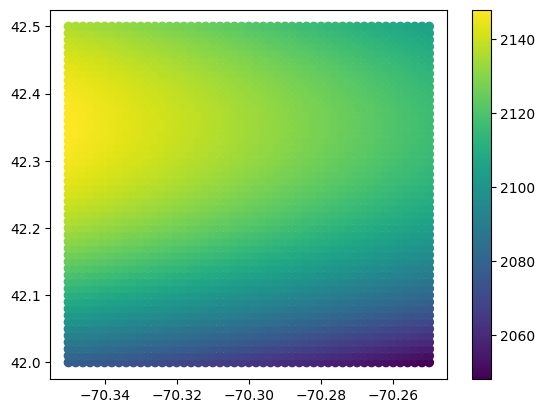

In [71]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced grid with x bounds [42, 42.5] and y bounds [-70.35, 71]
# Construct test points using meshgrid
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    x = torch.linspace(42, 42.5, 51)
    y = torch.linspace(-70.35, -70.25, 51)
    test_x = torch.stack(torch.meshgrid(x, y)).permute(1, 2, 0).reshape(-1, 2)
    observed_pred = likelihood(model(test_x))

with torch.no_grad():
    # Initialize plot
    plt.scatter(test_x[:, 1],test_x[:, 0], c=observed_pred.mean)
    plt.colorbar()

In [72]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(train_x))

/Users/becklabash/Library/Python/3.8/lib/python/site-packages/gpytorch/models/exact_gp.py:274: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


In [64]:
# Find the % error between observed_pred.mean and train_y
error = (observed_pred.mean - train_y) / train_y * 100

print('Mean error: %.3f%%' % error.mean().item())

Mean error: -0.059%


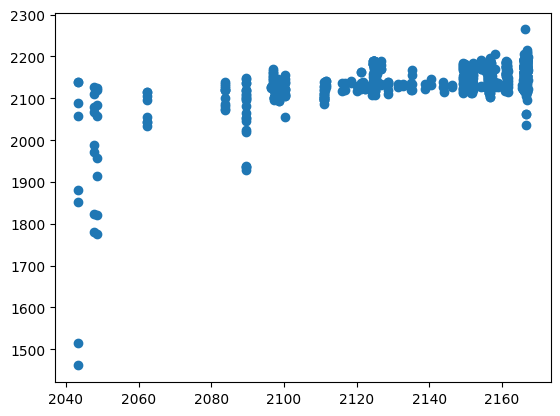

In [73]:
# Plot observed_pred.mean vs train_y
plt.scatter(observed_pred.mean, train_y)